# Finance Time Series Inference

Like in Stepanov et al., try to model the time series of the mean correlation value c_bar. We use their proposed shape for the multiplicative noise 

D_2 = L² * ( (c_bar - c_min)* (c_max - c_bar) ). Probably should use a prior c_min < c_bar < c_max.

Like Stepanov suspects, we introduce a time dependence in D_1 via the following trick:
Feed the data as 2d time series (x1, x2) with x2 = c_bar and x1 = t. Manually set dx1/dt = 1 (i.e. all coefficients for dx1/dt in the minimisation function).

In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from scipy import optimize
# from numba import jit
import pandas as pd

np.random.seed(1234)

n_noise = 3 # number of noise parameters: L, c_min, c_max
n_Drift = 8

In [2]:
## Define all the functions

#@jit
def poly(x,sigma):
    #x_vec=np.array([1,x[0],x[1],x[0]*x[0],x[1]*x[0],
    #                x[1]*x[1],x[0]*x[0]*x[0],x[1]*x[0]*x[0],x[1]*x[1]*x[0],x[1]*x[1]*x[1],
    #               x[0]**4, x[0]**3 * x[1], x[0]**2 * x[1]**2, x[0]*x[1]**3, x[1]**4],
    #               dtype=object)
    
    # decoupled ansatz, no constant because that would be collinear with time-trend
    x_vec=np.array([x[0],x[0]*x[0],x[0]**3 ,x[0]**4,
                   x[1],x[1]*x[1],x[1]**3 ,x[1]**4],
                    dtype=object)
    return np.dot(sigma,x_vec)



#@jit
def D1(sigma,x):
    # Make use of the fact that here, x_1 = t and hence dx_1/dt = 1
    sigma_d1 = sigma[n_noise:] # without noise parameters
    return poly(x.T, sigma_d1)


#@jit
def D2(alpha,x):
    return alpha[0]**2. *( (x[:,1]  - alpha[1]) * (alpha[2] - x[:,1]) )
    

#  Log Likelihood and negative logL

def log_likelihood(alpha,x,dt):
    # alpha is the current set of parameters
    # x is the entire data set N x 2
    # dt is the time difference
    
    log_like = 0 # initial value of sum
    
    #calculate D1 and D2 or each position in the data x
    
    minx = min(x[:,1])
    maxx = max(x[:,1])
    
    if alpha[0]>0 and  alpha[1] > 0. and alpha[1] < minx and alpha[2] > maxx : # noise must be positive and c_min < c_bar < c_max
        
        dx = x[1:,:]-x[:-1,:]  
        
        # only the x[:,1] component is the actual time series
        d1 = dx[:,1] - D1(alpha,x)[:-1]*dt
        d2 = D2(alpha,x)[:-1]
        d2_inv = d2**(-1.)
        log_like = ( -0.5*np.log(d2) - 0.5 * d2_inv * d1**2./dt -np.log(dt)).sum()        
        return log_like
    else:
        return -np.inf


def neg_log_likelihood(alpha,x,dt): #L Threshold Lambdac
    return -1*log_likelihood(alpha,x,dt)


# NEVER cut off all noise terms!
def cutIndex(Parameters, Threshold):
    Index = (np.abs(Parameters) < Threshold)
    Index[0:n_noise] = False
    return(Index)

def second_neg_log_likelihood(Coeff, Index,x,dt):
    # Index: Index of those coefficients which are set to 0: Boolean 
    Index = cutIndex(Coeff,L_thresh)
    Coeff[Index] = 0
    return -1*log_likelihood(Coeff,x,dt)


# BIC as goodness criterion for a threshold value

def BIC(alpha,x,dt,L): # mit Lambda Threshold
    
    logi = np.abs(alpha)>L # which are larger than Lambda?
    logi[0:n_noise] = True  # noise is always included
    return np.log(x[:,0].size)*np.sum(  logi ) - 2*log_likelihood(alpha, x,dt )


# Calculate BIC in the Loop with thresholding

def Loop(x, dt, L, a_Ini):
    # estimates alpha parameters based on starting values a_Ini for a given threshold L
    a_hat = optimize.minimize(neg_log_likelihood, a_Ini,args=(x,dt)) # max likelihood
    Estimation = a_hat["x"]
    Estimation[n_noise:] =  Estimation[n_noise:] * ( abs(Estimation[n_noise:] ) > L ) 
    
    for i in np.arange(0,n_Cut):
        Cut = (np.abs(Estimation)<L) # Boolean of the values that are cut off
        # second optimization with maxLikelEstimator as start:
        a_hat = optimize.minimize(second_neg_log_likelihood,Estimation,args = (Cut,x,dt))
        Estimation = a_hat["x"]
        Estimation[n_noise:] =  Estimation[n_noise:] * ( abs(Estimation[n_noise:] ) > L )
    return(Estimation)




(5251, 2)
           t     c_bar
0      0.000  0.100816
1      0.004  0.098629
2      0.008  0.095379
3      0.012  0.093081
4      0.016  0.092683
...      ...       ...
5246  20.984  0.299250
5247  20.988  0.305746
5248  20.992  0.317696
5249  20.996  0.322748
5250  21.000  0.338906

[5251 rows x 2 columns]


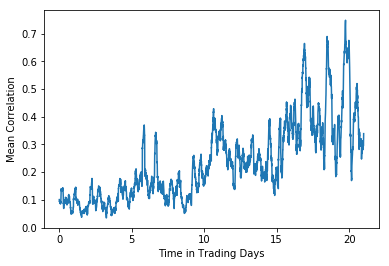

In [3]:
#Get Data
filename = 'TimeSeries_Finance_Reduced'    # 2D data x1, x2
x = pd.read_csv(filename, header = 0, index_col = 0)
dt = 1/250  # 250 trading days are a trading year
print(x.shape)
x["t"] = dt * np.arange(0,x.shape[0],1) # time index should not be datetime
print(x)
x = x.to_numpy()
plt.plot(x[:,0], x[:,1])
plt.xlabel("Time in Trading Days")
plt.ylabel("Mean Correlation")
plt.show()

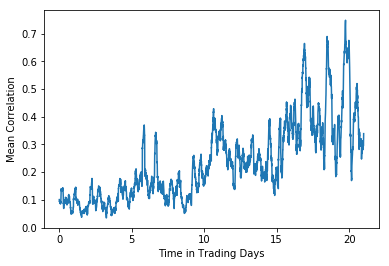

In [4]:
plt.plot(x[:,0], x[:,1])
plt.xlabel("Time in Trading Days")
plt.ylabel("Mean Correlation")
plt.savefig("FinanceData")
plt.show()

In [5]:
dx = x[1:]-x[:-1]  
Lambda = 0.5 # initial threshold

N = x[:,0].size

In [6]:
# Set up variables for the hyperparameter search on threshold

n_Cut = 5 # Number of reiterating
hp1 = np.arange(0.00,1.5, 0.1) # list of possible thresholds
n_Iteration = len(hp1) # Number of Hyperparameter search iterations
score = np.empty(n_Iteration) # score for Hyperparameters


# In[5]:

In [7]:
TestAl = np.ones(n_noise + n_Drift)   # sample parameters to start the search

#Starting values for noise range:
TestAl[0] = 1./np.sqrt(6.) # roughly taken from the Stepanov paper but scaled to trading years instead of days
TestAl[1] = 0.9 * min(x[:,1])
TestAl[2] = 1.5 * max(x[:,1])
print(TestAl)


#### Initial Guess

TestAl = optimize.minimize(neg_log_likelihood,TestAl,args=(x,dt)) 
# first estimation with maybe less than full data

TestAl = TestAl["x"]

AlphaList = np.empty((n_Iteration, n_noise+n_Drift))
print(TestAl)

[0.40824829 0.03120007 1.12236204 1.         1.         1.
 1.         1.         1.         1.         1.        ]


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 1.91590458e-01  3.46647648e-02  1.41192958e+00  7.52852096e-02
 -1.64858247e-02  1.61813228e-03 -4.50806470e-05  1.06133306e+00
 -2.01290864e+01  4.36486139e+01 -2.81957070e+01]


In [8]:
for i in range(n_Iteration):
    L_thresh = hp1[i]
    estimate = Loop(x, dt, hp1[i], TestAl)
    AlphaList[i,:] = estimate
    score[i] = BIC(estimate, x, dt, hp1[i])
    print(estimate)
    print(hp1[i], score[i])


np.savetxt('Alpha_Done.txt',AlphaList)
d = {'Threshold': hp1, 'BIC': score}
df = pd.DataFrame(data=d)
print(df)
df.to_csv("Score_BIC.csv")



/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[ 3.04779006e-01  2.24172404e-02  1.40451241e+00  9.43346680e-02
 -1.92047287e-02  1.76909084e-03 -4.79897776e-05  4.87891255e-01
 -1.75995415e+01  3.95196027e+01 -2.59867824e+01]
0.0 -73777.18834486436


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.05399938e-01  2.22534587e-02  1.40183604e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.31836892e+00
 -1.71409069e+01  3.79200060e+01 -2.73524178e+01]
0.1 -73794.07498961383


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.05399938e-01  2.22534587e-02  1.40183604e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.31836892e+00
 -1.71409069e+01  3.79200060e+01 -2.73524178e+01]
0.2 -73794.07498961383


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.05399938e-01  2.22534587e-02  1.40183604e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.31836892e+00
 -1.71409069e+01  3.79200060e+01 -2.73524178e+01]
0.30000000000000004 -73794.07498961383


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.05399938e-01  2.22534587e-02  1.40183604e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  2.31836892e+00
 -1.71409069e+01  3.79200060e+01 -2.73524178e+01]
0.4 -73794.07498961383


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
0.5 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
0.6000000000000001 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
0.7000000000000001 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
0.8 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
0.9 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
1.0 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
1.1 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[ 3.01811183e-01  2.19285295e-02  1.42699340e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.23552521e+00 -2.83023296e+01  2.78097003e+01]
1.2000000000000002 -73798.85625257011


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/py

[ 0.30450479  0.02195943  1.40750382  0.         -0.          0.
 -0.          0.         -0.         -0.         -1.39679658]
1.3 -73812.08175595122


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


[  0.32025751   0.02248964   1.30056519   0.          -0.
   0.          -0.           0.          -1.40089358   8.15577541
 -11.15429982]
1.4000000000000001 -73792.1910655769
    Threshold           BIC
0         0.0 -73777.188345
1         0.1 -73794.074990
2         0.2 -73794.074990
3         0.3 -73794.074990
4         0.4 -73794.074990
5         0.5 -73798.856253
6         0.6 -73798.856253
7         0.7 -73798.856253
8         0.8 -73798.856253
9         0.9 -73798.856253
10        1.0 -73798.856253
11        1.1 -73798.856253
12        1.2 -73798.856253
13        1.3 -73812.081756
14        1.4 -73792.191066


/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/users/t_wand01/.local/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:557: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [9]:
print(df)


    Threshold           BIC
0         0.0 -73777.188345
1         0.1 -73794.074990
2         0.2 -73794.074990
3         0.3 -73794.074990
4         0.4 -73794.074990
5         0.5 -73798.856253
6         0.6 -73798.856253
7         0.7 -73798.856253
8         0.8 -73798.856253
9         0.9 -73798.856253
10        1.0 -73798.856253
11        1.1 -73798.856253
12        1.2 -73798.856253
13        1.3 -73812.081756
14        1.4 -73792.191066


In [10]:
BestThreshold = df.loc[df['BIC'].idxmin()]['Threshold']


In [11]:
print("Minimum apparently at a threshold of", BestThreshold)

Minimum apparently at a threshold of 1.3


### Test what the estimator is actually trying to suggest

Look at the best result for the lowest BIC.

In [12]:
BestThreshold = df.loc[df['BIC'].idxmin()]['Threshold']
A_hat = AlphaList[0,:]
A_hat_cut = A_hat*(abs(A_hat)>BestThreshold)
print(A_hat_cut[n_noise:])

[  0.          -0.           0.          -0.           0.
 -17.59954145  39.51960266 -25.98678244]


In [13]:
print(min(x[:,1]), A_hat[1])
print(max(x[:,1]), A_hat[2])

0.0346667459312917 0.022417240372272246
0.7482413609197618 1.4045124111066258


In [14]:
print(D1(A_hat,x)[:-1].shape)
print(dx.shape)

(5250,)
(5250, 2)


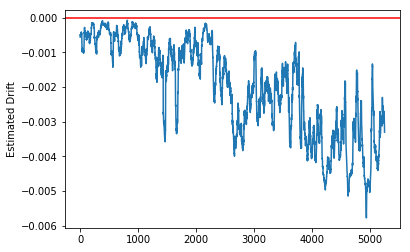

In [15]:
plt.plot(dt*D1(A_hat_cut, x))
plt.ylabel("Estimated Drift")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

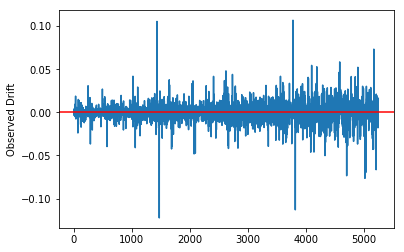

In [16]:
plt.plot(x[1:,1] - x[:-1,1])
plt.ylabel("Observed Drift")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

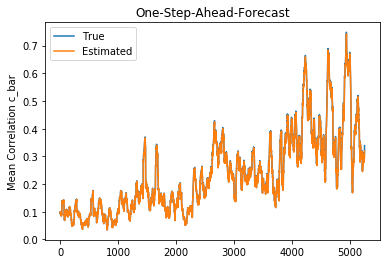

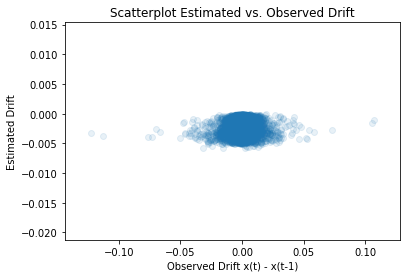

In [17]:
x_hat =  x[:-1,1] + dt*D1(A_hat_cut, x)[:-1]
x_true = x[1:,1]

Diffx_true = x[1:,1] - x[:-1,1]
Diffx_hat = dt*D1(A_hat_cut, x)[:-1]

plt.plot(x_true, label="True")
plt.plot(x_hat,label="Estimated")
plt.legend()
plt.ylabel("Mean Correlation c_bar")
plt.title("One-Step-Ahead-Forecast")
plt.show()

plt.title("Scatterplot Estimated vs. Observed Drift")
plt.scatter(Diffx_true,
            Diffx_hat,
            alpha=0.1)
plt.xlabel("Observed Drift x(t) - x(t-1)")
plt.ylabel("Estimated Drift")
#plt.plot((0,0.7), (0,0.7), color="red")
plt.show()

As a comparison: just plot x_hat = x(t-1) vs x(t)


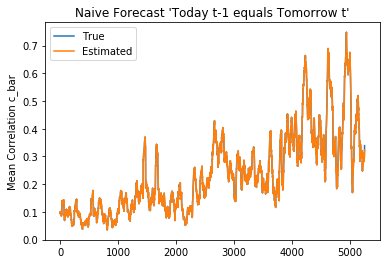

In [18]:
x_hat2 =  x[:-1,1] 
x_true = x[1:,1]

plt.plot(x_true, label="True")
plt.plot(x_hat2,label="Estimated")
plt.legend()
plt.ylabel("Mean Correlation c_bar")
plt.title("Naive Forecast 'Today t-1 equals Tomorrow t'")
plt.show()

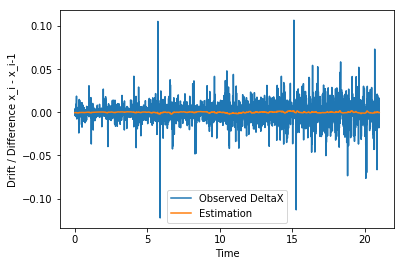

In [19]:
plt.plot(x[1:,0],dx[:,1], label = "Observed DeltaX")
plt.plot(x[1:,0],dt*D1(A_hat, x)[:-1], label="Estimation")
plt.legend()
plt.ylabel("Drift / Difference x_i - x_i-1")
plt.xlabel("Time")
plt.show()

### Check the Noise Sequence

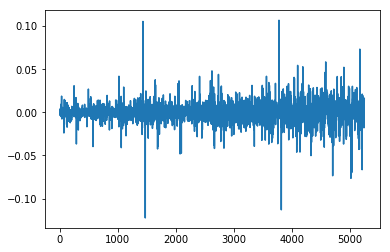

In [20]:
dc_bar = dx[:,1]
plt.plot(dc_bar)
plt.show()